### Unidade Morumbi — Análise Socioeconômica e Populacional

Esta análise utiliza dados censitários do **IBGE (Censo 2022)** em um raio de **5 km** ao redor da **Unidade Morumbi – Colégio Elvira Brandão**, localizada na **Vila Suzana**.  
O objetivo é compreender o perfil **socioeconômico e populacional** da região, auxiliando na identificação de fatores que podem impactar a **adesão e retenção de leads**, especialmente relacionados a questões **financeiras e de poder aquisitivo**.  

Os dados foram obtidos a partir de fontes oficiais do IBGE:  
- [Censo IBGE 2022 — Dados Demográficos](https://censo2022.ibge.gov.br/)  
- [API IBGE — Indicadores Sociais e Econômicos](https://servicodados.ibge.gov.br/api/docs/)

## Bibliotecas e Análise Exploratória das Colunas e Bairros da Região

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from branca.element import MacroElement
from jinja2 import Template
import html
import os
from IPython.display import IFrame, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carregar CSV
df = pd.read_csv('Elvira Brandão Morumbi - Euvira Brandão Dados ADS_coords_corrigidas_com_enderecos.csv')

In [10]:
# Verificar as colunas disponíveis
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())

Colunas disponíveis no DataFrame:
['id', 'ano', 'latitude_centro', 'longitude_centro', 'radius', 'distance_unit', 'populacao_total', 'renda_media', 'v01031_0_4anos', 'v01032_5_9anos', 'v01033_10_14anos', 'v01034_15_19anos', 'Total', 'CEP', 'Bairro', 'Cidade', 'UF', 'Logradouro']


In [11]:
# Mostrar todos os bairros únicos
print("Bairros disponíveis:")
print(df['Bairro'].unique())

Bairros disponíveis:
['Granja Julieta' 'Vila Andrade' 'Paraisópolis' 'Brooklin Novo' 'Morumbi'
 'Chácara Santo Antônio' 'Cidade Jardim' 'Vila Olímpia' 'Butantã'
 'Vila Sônia' 'Itaim Bibi' 'Jardim Dracena' 'Santo Amaro' 'Ferreira'
 'Jardim São Luís' 'Campo Limpo' 'Jardim Maria Duarte' 'Jardim Petrópolis'
 'Jardim Jussara' 'Rio Pequeno' 'Caxingui' 'Parque Pinheiros'
 'Chácara Marapuí' 'Parque Albina' 'Jardim Maria Rosa' 'Capão Redondo'
 'Jardim Guaraú' 'Jardim Helena' 'Parque dos Príncipes' 'Parque Assunção'
 'Jardim Monte Alegre' 'Parque Marabá' 'Jardim Bontempo' 'Centro'
 'Cidade Intercap' 'Jardim Pedro Gonçalves' 'Jardim Boa Vista']


# 1. Distribuição Geográfica dos Dados

In [12]:
# Dados do colégio (coordenadas confirmadas)
# Dados do colégio (Morumbi)
escola_nome = 'Unidade Morumbi - Elvira Brandão'
escola_endereco = 'R. Mal. Hastimphilo de Moura, 27 - Vila Suzana, São Paulo - SP, 05641-000'
escola_lat = -23.6164
escola_lon = -46.73831

# Salário mínimo (usa valor existente ou padrão)
salario_minimo = globals().get('salario_minimo', 1380.0)

# Garante que df esteja carregado e normaliza renda_media
if 'df' not in globals():
    raise RuntimeError('DataFrame `df` não está carregado. Rode a célula de leitura do CSV antes.')
if 'renda_media' in df.columns:
    df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False).str.replace(r'\s+', '', regex=True)
    df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
else:
    df['renda_media'] = pd.NA
df['renda_sm'] = df['renda_media'] / salario_minimo

# Formatação BRL para popups
def fmt_brl(x):
    try:
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return 'Sem dado'
        v = float(x)
        s = f"{v:,.2f}"
        s = s.replace(',','X').replace('.',',').replace('X','.')
        return f"R$ {s}"
    except Exception:
        return str(x)

# Cores sólidas solicitadas pelo usuário
CORES_SM = {
    '≤1': "#2f7eed",    # Azul claro
    '1-2': '#ffffb3',   # Amarelo claro
    '2-5': '#fdbf00',   # Amarelo escuro
    '5-10': '#ff7f0e',  # Laranja
    '>10': '#d62728',   # Vermelho
    'Sem dado': '#7f7f7f',
}

def faixa_cor_label(r_sm):
    if pd.isna(r_sm):
        return (CORES_SM['Sem dado'], 'Sem dado')
    if r_sm <= 1:
        return (CORES_SM['≤1'], '≤ 1 SM')
    if r_sm <= 2:
        return (CORES_SM['1-2'], '1-2 SM')
    if r_sm <= 5:
        return (CORES_SM['2-5'], '2-5 SM')
    if r_sm <= 10:
        return (CORES_SM['5-10'], '5-10 SM')
    return (CORES_SM['>10'], '> 10 SM')

# Calcula contagens por faixa para legendas
total = len(df)
bins = [(-np.inf,1,'≤1'), (1,2,'1-2'), (2,5,'2-5'), (5,10,'5-10'), (10,np.inf,'>10')]
counts = {}
for lo, hi, key in bins:
    if lo == -np.inf:
        mask = df['renda_sm'] <= hi
    elif hi == np.inf:
        mask = df['renda_sm'] > lo
    else:
        mask = (df['renda_sm'] > lo) & (df['renda_sm'] <= hi)
    cnt = int(mask.sum()) if total>0 else 0
    pct = (cnt/total*100) if total>0 else 0
    counts[key] = {'count': cnt, 'pct': pct}

# Centro do mapa: prefere map_center/lat/lon, senão coordenadas do colégio
if 'map_center' in globals() and isinstance(map_center, (list, tuple)) and len(map_center) >= 2:
    centro = map_center[:2]
elif 'lat' in globals() and 'lon' in globals():
    centro = [lat, lon]
else:
    centro = [escola_lat, escola_lon]

m = folium.Map(location=centro, zoom_start=13, tiles='OpenStreetMap')

# Adiciona marcadores com cor sólida e contagem no popup
for _, row in df.iterrows():
    try:
        if 'latitude_centro' in df.columns and 'longitude_centro' in df.columns:
            lat_row = row.get('latitude_centro')
            lon_row = row.get('longitude_centro')
        elif 'latitude' in df.columns and 'longitude' in df.columns:
            lat_row = row.get('latitude')
            lon_row = row.get('longitude')
        else:
            lat_row = row.get('lat') or row.get('LAT') or row.get('Latitude')
            lon_row = row.get('lon') or row.get('LON') or row.get('Longitude')
        if pd.isna(lat_row) or pd.isna(lon_row):
            continue
        latf = float(lat_row)
        lonf = float(lon_row)
        color, label = faixa_cor_label(row.get('renda_sm', np.nan))
        renda_form = fmt_brl(row.get('renda_media'))
        renda_sm_val = row.get('renda_sm', np.nan)
        renda_sm_str = f"{renda_sm_val:.2f}" if not pd.isna(renda_sm_val) else 'Sem dado'
        popup_html = f"CEP: {html.escape(str(row.get('CEP','')))}<br>Bairro: {html.escape(str(row.get('Bairro','')))}<br>Rua: {html.escape(str(row.get('Logradouro','')))}<br>Renda média: {renda_form}<br>Renda (SM): {renda_sm_str}"
        folium.CircleMarker(location=[latf, lonf], radius=6, color='black', weight=0.5, fill=True, fill_color=color, fill_opacity=0.95, popup=folium.Popup(popup_html, max_width=300)).add_to(m)
    except Exception:
        continue

# Marcador do colégio com coordenadas exatas e popup correto
folium.Marker(location=[escola_lat, escola_lon], popup=folium.Popup(f"<b>{escola_nome}</b><br>{escola_endereco}", max_width=350), icon=folium.Icon(color='purple', icon='star')).add_to(m)

# Cria HTML da legenda com contagens e cores
legend_items = [
    (CORES_SM['≤1'], f"≤ 1 SM — {counts['≤1']['count']} CEPs ({counts['≤1']['pct']:.1f}%) — Até {fmt_brl(salario_minimo)}"),
    (CORES_SM['1-2'], f"1-2 SM — {counts['1-2']['count']} CEPs ({counts['1-2']['pct']:.1f}%) — {fmt_brl(salario_minimo*2)}"),
    (CORES_SM['2-5'], f"2-5 SM — {counts['2-5']['count']} CEPs ({counts['2-5']['pct']:.1f}%)"),
    (CORES_SM['5-10'], f"5-10 SM — {counts['5-10']['count']} CEPs ({counts['5-10']['pct']:.1f}%)"),
    (CORES_SM['>10'], f"> 10 SM — {counts['>10']['count']} CEPs ({counts['>10']['pct']:.1f}%)"),
]

legend_html = """{% macro html(this, kwargs) %}\n<div style=\"position: fixed; bottom: 50px; left: 50px; width: 340px; z-index:9999; font-size:13px;\">\n  <div style=\"background:white; padding:10px; border:2px solid grey;\">\n    <b>Faixas (SM)</b><br>\n    __ITEMS__\n  </div>\n</div>\n{% endmacro %}\n"""
items_html = ''.join([f"<div style=\"margin-top:6px;\"><span style=\"display:inline-block;width:16px;height:10px;background:{c};margin-right:6px;\"></span> {txt}</div>" for c, txt in legend_items])
legend_html = legend_html.replace('__ITEMS__', items_html)
macro = MacroElement()
macro._template = Template(legend_html)
m.get_root().add_child(macro)

# Salva o mapa atualizado
m.save('mapa_interativo_chacara.html')
print('Mapa salvo em mapa_interativo_chacara.html — centro:', centro)

Mapa salvo em mapa_interativo_chacara.html — centro: [-23.6164, -46.73831]


In [13]:
# Exibir o mapa interativo salvo em 'mapa_interativo_chacara.html'
# Prioriza exibir o objeto folium 'm' se ele existir no kernel, senão usa IFrame,
# e como fallback tenta abrir no navegador padrão.
try:
    display(m)
except Exception:
    pass
map_path = 'mapa_interativo_chacara.html'
if os.path.exists(map_path):
    try:
        display(IFrame(map_path, width=900, height=600))
    except Exception:
        import webbrowser
        webbrowser.open(os.path.abspath(map_path))
else:
    print(f'Arquivo {map_path} não encontrado. Rode a célula que gera o mapa primeiro.')

# 2. Análise de Correlação entre Variáveis

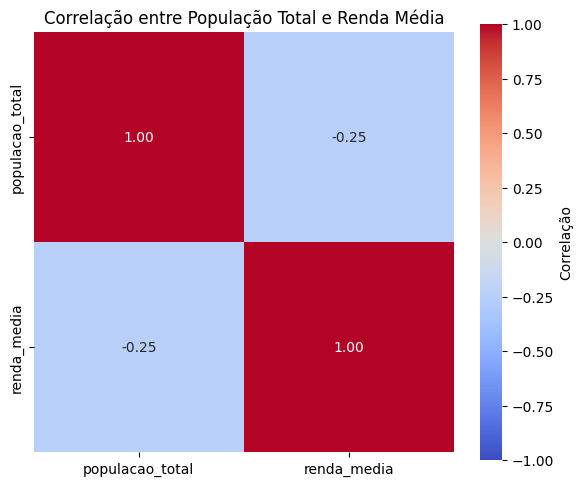

Correlação de Pearson: -0.251
Amostras analisadas: 1881


In [14]:
# Correlação entre população e renda média

# Carregar CSV (opcional — primeira célula já carrega `df`)
if 'df' not in globals():
    df = pd.read_csv('Elvira Brandão Morumbi - Euvira Brandão Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter colunas numéricas
if 'renda_media' in df.columns:
    df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
    df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
else:
    df['renda_media'] = pd.NA

if 'populacao_total' in df.columns:
    df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

corr_data = df[['populacao_total', 'renda_media']].dropna()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlação'})
plt.title('Correlação entre População Total e Renda Média')
plt.tight_layout()
plt.show()

# Calcular e exibir correlação de Pearson
pearson_corr = corr_data['populacao_total'].corr(corr_data['renda_media'])
print(f'Correlação de Pearson: {pearson_corr:.3f}')
print(f'Amostras analisadas: {len(corr_data)}')

In [15]:
# Mostrar estatísticas descritivas (usa `df` carregado na célula inicial)
if 'df' not in globals():
    df = pd.read_csv('Elvira Brandão Morumbi - Euvira Brandão Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter colunas numéricas
if 'renda_media' in df.columns:
    df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
    df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

if 'populacao_total' in df.columns:
    df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Mostrar estatísticas descritivas
print("\nEstatísticas:")
print(f"Número de CEPs analisados: {len(df)}")
print(f"População total: {df['populacao_total'].sum():,}")
print(f"Renda média: R$ {df['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df['renda_media'].max():,.2f}")


Estatísticas:
Número de CEPs analisados: 1881
População total: 793,680
Renda média: R$ 7,591.59
Renda média mínima: R$ 1,153.62
Renda média máxima: R$ 73,198.95


<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
A análise geral, considerando todas as regiões avaliadas, compreende 1.881 amostras, totalizando uma população de 
aproximadamente 793.680 habitantes e renda média de R$ 7.591,59. Os valores de renda variam amplamente, indo de 
R$ 1.153,62 a R$ 73.198,95, evidenciando uma grande desigualdade socioeconômica entre as áreas. O coeficiente de 
correlação de -0,25 indica uma relação negativa fraca entre população e renda média, sugerindo que regiões mais 
densamente povoadas tendem a apresentar rendas menores. Essa tendência aponta para o padrão típico de grandes centros 
urbanos, em que a concentração populacional está associada a áreas de menor renda média, refletindo disparidades 
socioeconômicas estruturais e a heterogeneidade urbana da cidade.

</div>


# Correlação entre População Total e Renda Média
Ferreira, Vila Sônia e Paraisópolis

## Bairro Ferreira

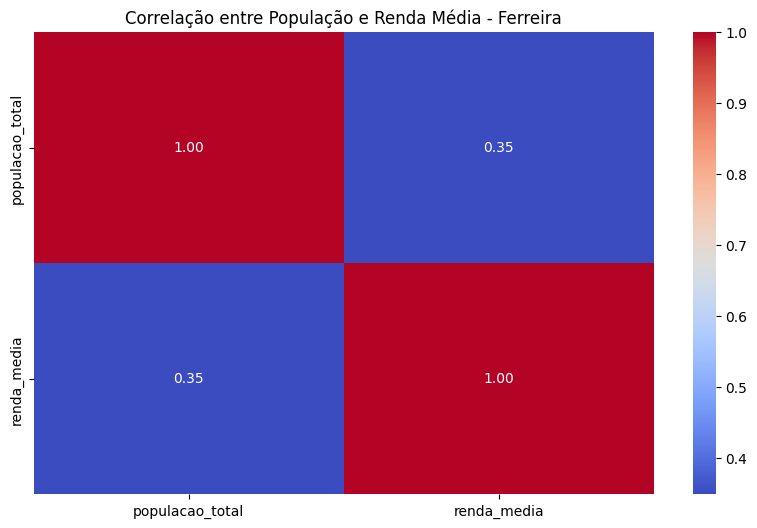


Estatísticas do bairro Ferreira:
Número de CEPs analisados: 92
População total do bairro: 31,306
Renda média do bairro: R$ 7,793.39
Renda média mínima: R$ 1,317.33
Renda média máxima: R$ 20,294.88


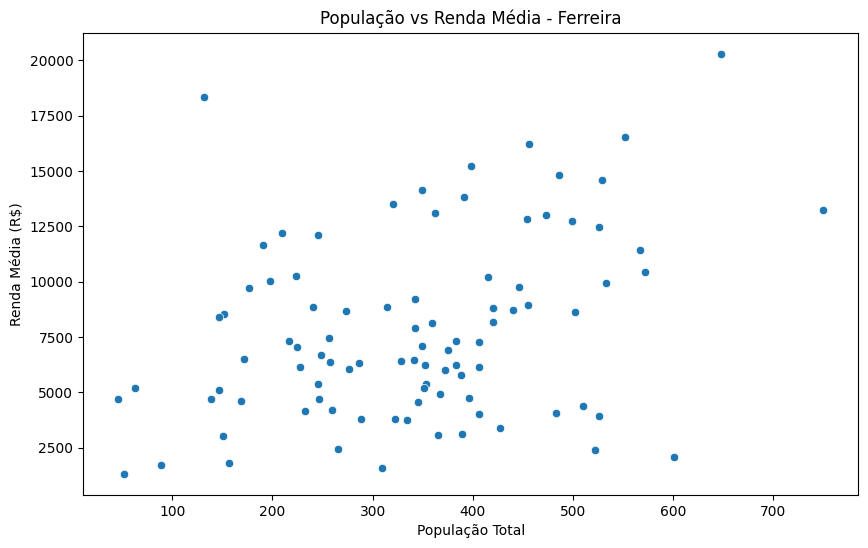

In [16]:
# Converter colunas numéricas (robusta, suporta vírgula decimal)
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Filtrar apenas dados da Vila Sônia
df_ferreira = df[df['Bairro'] == 'Ferreira']

# Análise de correlação entre população e renda média para Ferreira
plt.figure(figsize=(10, 6))
sns.heatmap(df_ferreira[['populacao_total', 'renda_media']].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')

# Exibir gráfico
plt.title('Correlação entre População e Renda Média - Ferreira')
plt.show()

# Mostrar estatísticas descritivas do bairro
print("\nEstatísticas do bairro Ferreira:")
print(f"Número de CEPs analisados: {len(df_ferreira)}")
print(f"População total do bairro: {df_ferreira['populacao_total'].sum():,}")
print(f"Renda média do bairro: R$ {df_ferreira['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df_ferreira['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df_ferreira['renda_media'].max():,.2f}")

# Adicionar gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ferreira, x='populacao_total', y='renda_media')
plt.title('População vs Renda Média - Ferreira')
plt.xlabel('População Total')
plt.ylabel('Renda Média (R$)')
plt.show()

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O bairro Ferreira apresenta renda média de R$ 7.793,39 e população total de aproximadamente 31 mil habitantes, 
com grande variação de renda entre os CEPs. A correlação de 0,35 indica uma relação positiva, porém fraca, 
entre população e renda média. O gráfico de dispersão evidencia pontos amplamente distribuídos, 
mostrando diferenças internas relevantes. O bairro possui perfil heterogêneo, combinando áreas de classe média e alta, 
o que reflete diversidade socioeconômica típica de regiões urbanas consolidadas.

</div>

## Bairro Vila Sônia

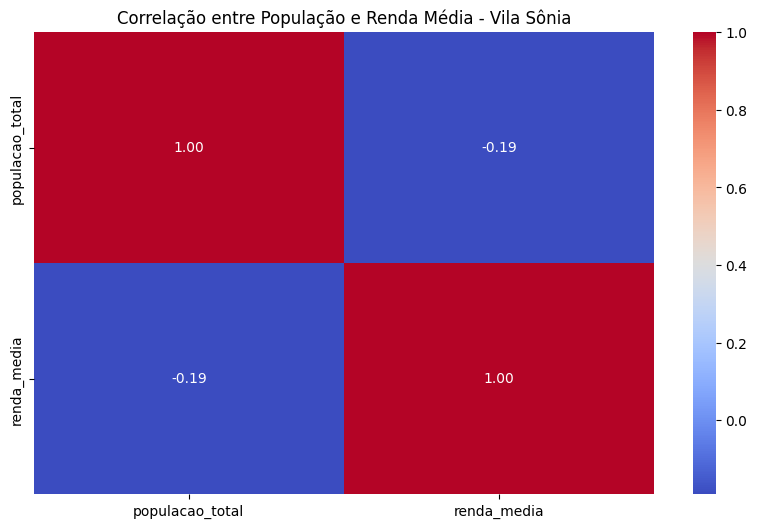


Estatísticas do bairro Vila Sônia:
Número de CEPs analisados: 206
População total do bairro: 87,534
Renda média do bairro: R$ 6,763.88
Renda média mínima: R$ 1,336.68
Renda média máxima: R$ 36,298.90


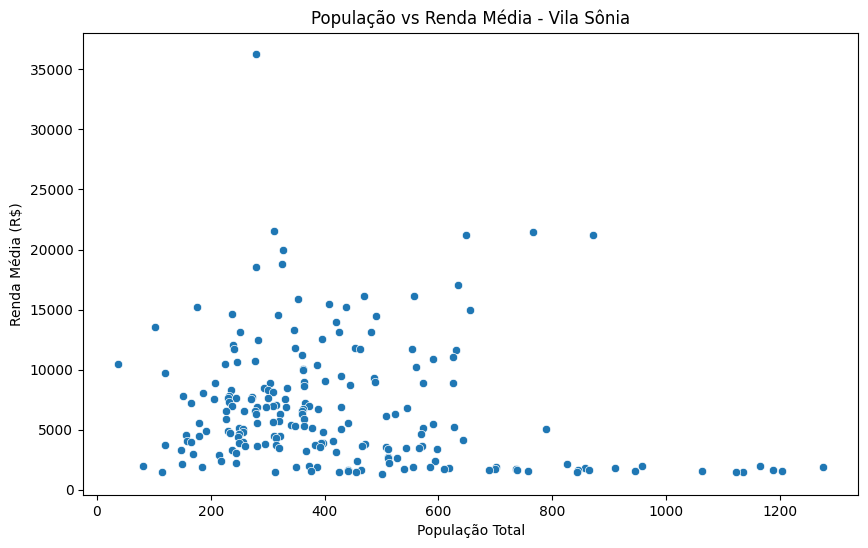

In [17]:
# Converter colunas numéricas (robusta, suporta vírgula decimal)
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Filtrar apenas dados da Vila Sônia
df_sonia = df[df['Bairro'] == 'Vila Sônia']

# Análise de correlação entre população e renda média para Vila Sônia
plt.figure(figsize=(10, 6))
sns.heatmap(df_sonia[['populacao_total', 'renda_media']].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')

# Exibir gráfico
plt.title('Correlação entre População e Renda Média - Vila Sônia')
plt.show()

# Mostrar estatísticas descritivas do bairro
print("\nEstatísticas do bairro Vila Sônia:")
print(f"Número de CEPs analisados: {len(df_sonia)}")
print(f"População total do bairro: {df_sonia['populacao_total'].sum():,}")
print(f"Renda média do bairro: R$ {df_sonia['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df_sonia['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df_sonia['renda_media'].max():,.2f}")

# Adicionar gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sonia, x='populacao_total', y='renda_media')
plt.title('População vs Renda Média - Vila Sônia')
plt.xlabel('População Total')
plt.ylabel('Renda Média (R$)')
plt.show()

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O bairro Vila Sônia possui 206 CEPs analisados, com uma população total de aproximadamente 87.534 habitantes 
e renda média de R$ 6.763,88. A variação entre as rendas mínima (R$ 1.336,68) e máxima (R$ 36.298,90) 
indica alta disparidade econômica dentro do bairro. O coeficiente de correlação de -0,19 mostra uma relação negativa fraca 
entre população e renda média, sugerindo que áreas mais populosas tendem a apresentar rendas ligeiramente menores. 
O gráfico de dispersão confirma essa ausência de padrão linear, com pontos amplamente distribuídos. 
Em síntese, Vila Sônia apresenta um perfil heterogêneo, reunindo áreas de classe média e alta, com contrastes marcantes 
de renda e ocupação, característicos de regiões urbanas diversas.

</div>

## Bairro Paraisópolis

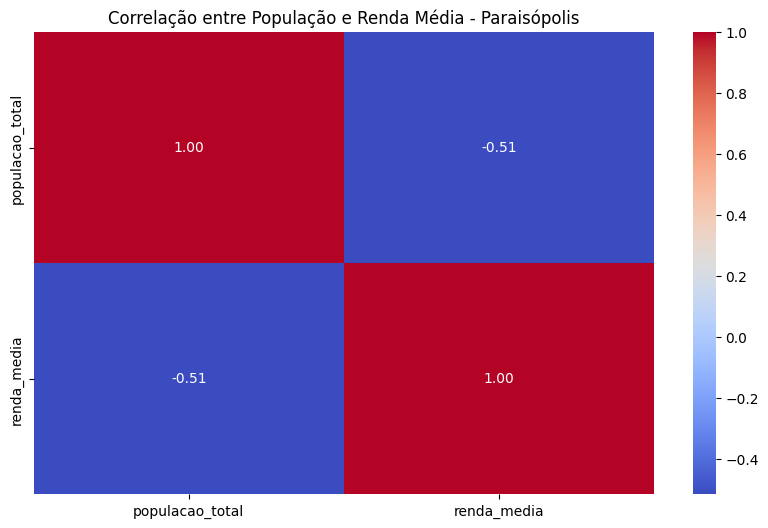


Estatísticas do bairro Paraisópolis:
Número de CEPs analisados: 156
População total do bairro: 81,632
Renda média do bairro: R$ 8,728.06
Renda média mínima: R$ 1,417.69
Renda média máxima: R$ 34,652.59


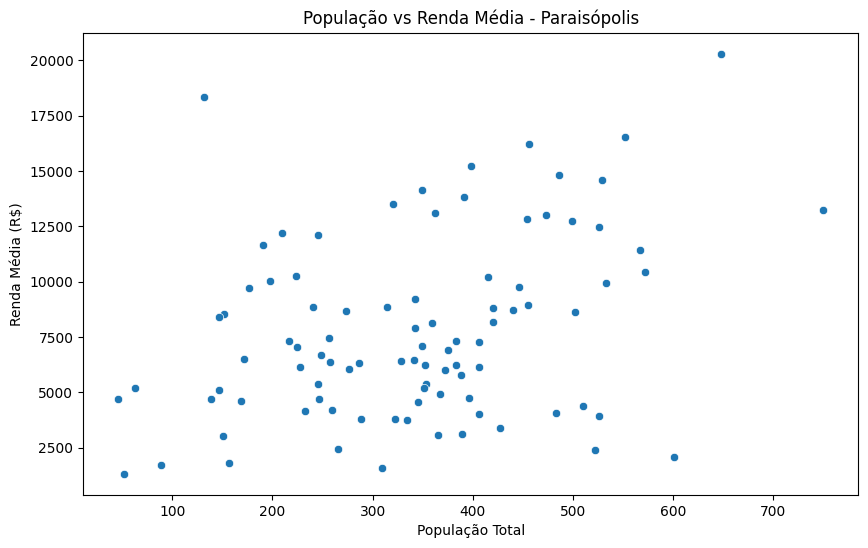

In [18]:
# Converter colunas numéricas (robusta, suporta vírgula decimal)
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Filtrar apenas dados da Paraisópolis
df_paraisopolis = df[df['Bairro'] == 'Paraisópolis']

# Análise de correlação entre população e renda média para Ferreira
plt.figure(figsize=(10, 6))
sns.heatmap(df_paraisopolis[['populacao_total', 'renda_media']].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')

# Exibir gráfico
plt.title('Correlação entre População e Renda Média - Paraisópolis')
plt.show()

# Mostrar estatísticas descritivas do bairro
print("\nEstatísticas do bairro Paraisópolis:")
print(f"Número de CEPs analisados: {len(df_paraisopolis)}")
print(f"População total do bairro: {df_paraisopolis['populacao_total'].sum():,}")
print(f"Renda média do bairro: R$ {df_paraisopolis['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df_paraisopolis['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df_paraisopolis['renda_media'].max():,.2f}")

# Adicionar gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ferreira, x='populacao_total', y='renda_media')
plt.title('População vs Renda Média - Paraisópolis')
plt.xlabel('População Total')
plt.ylabel('Renda Média (R$)')
plt.show()

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O bairro Paraisópolis apresenta 156 CEPs analisados, com uma população total estimada em 81.632 habitantes 
e renda média de R$ 8.728,06. A renda mínima registrada é de R$ 1.417,69 e a máxima de R$ 34.652,59, 
mostrando uma diferença considerável entre as regiões do bairro. O coeficiente de correlação de -0,51 indica 
uma relação negativa moderada entre população e renda média — ou seja, áreas mais populosas tendem a ter rendas 
menores, enquanto regiões menos densas concentram maior poder aquisitivo. O gráfico de dispersão reforça essa 
tendência, evidenciando maior concentração de pontos com baixa renda em zonas de alta densidade. 
De forma geral, Paraisópolis apresenta um perfil socioeconômico desigual, caracterizado por contrastes marcantes 
entre concentração populacional e renda, refletindo os desafios de urbanização e desigualdade social da região.

</div>

# 3. Distribuição de Renda (Salários Mínimos) — 10 Bairros Mais Próximos à Escola Elvira Brandão Chácara

C:\Users\00157NLUC-BrenoR\AppData\Local\Temp\ipykernel_20504\3102094421.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bairro', y='renda_sm', data=df_proximos, order=top_bairros, palette='Set2')


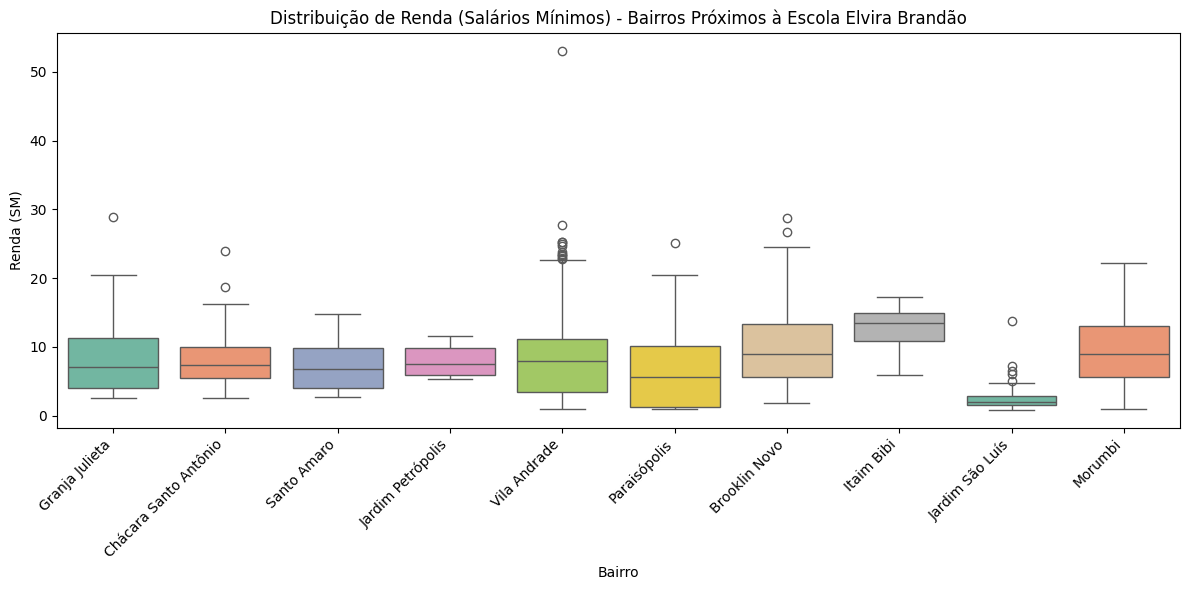


Bairros mais próximos da Escola Elvira Brandão:
1. Granja Julieta: Renda média = 8.31 SM (R$ 11,462.59)
2. Chácara Santo Antônio: Renda média = 8.34 SM (R$ 11,505.43)
3. Santo Amaro: Renda média = 7.22 SM (R$ 9,965.43)
4. Jardim Petrópolis: Renda média = 8.01 SM (R$ 11,050.71)
5. Vila Andrade: Renda média = 8.79 SM (R$ 12,134.23)
6. Paraisópolis: Renda média = 6.32 SM (R$ 8,728.06)
7. Brooklin Novo: Renda média = 10.58 SM (R$ 14,594.89)
8. Itaim Bibi: Renda média = 12.51 SM (R$ 17,260.65)
9. Jardim São Luís: Renda média = 2.51 SM (R$ 3,459.84)
10. Morumbi: Renda média = 9.00 SM (R$ 12,424.34)


In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar CSV com os dados
df = pd.read_csv('Elvira Brandão Morumbi - Euvira Brandão Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter renda_media: substituir vírgula por ponto
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

# Calcular renda em salários mínimos
salario_minimo = 1380.0
df['renda_sm'] = df['renda_media'] / salario_minimo

# Coordenadas da Escola Elvira Brandão
escola_lat = -23.6336779
escola_lon = -46.7132727

# Calcular distância de cada CEP até a escola (aproximação simples usando Pitagoras)
df['distancia'] = np.sqrt((df['latitude_centro'] - escola_lat)**2 + (df['longitude_centro'] - escola_lon)**2)

# Selecionar os 10 bairros mais próximos (agrupando por bairro e pegando a distância média)
bairro_dist = df.groupby('Bairro')['distancia'].mean().sort_values()
top_bairros = bairro_dist.head(10).index.tolist()

# Filtrar dados apenas dos bairros mais próximos
df_proximos = df[df['Bairro'].isin(top_bairros)].copy()

# Plotando a distribuição de renda em SM por bairro (ordenado por proximidade)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bairro', y='renda_sm', data=df_proximos, order=top_bairros, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição de Renda (Salários Mínimos) - Bairros Próximos à Escola Elvira Brandão')
plt.ylabel('Renda (SM)')
plt.xlabel('Bairro')
plt.tight_layout()
plt.show()

# Estatísticas dos bairros mais próximos
print("\nBairros mais próximos da Escola Elvira Brandão:")
for i, bairro in enumerate(top_bairros, 1):
    df_bairro = df_proximos[df_proximos['Bairro'] == bairro]
    media_sm = df_bairro['renda_sm'].mean()
    print(f"{i}. {bairro}: Renda média = {media_sm:.2f} SM (R$ {media_sm * salario_minimo:,.2f})")

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O boxplot apresenta a distribuição da renda média convertida em salários mínimos (SM) para os 10 bairros mais próximos à Escola Elvira Brandão, ordenados por proximidade. A figura permite comparar mediana, dispersão e outliers entre bairros, evidenciando diferenças socioeconômicas relevantes.
<br><br>
Destaques por renda média:<br>
• Itaim Bibi ≈ 12,51 SM (R$ 17.260,65) — patamar mais alto.<br>
• Brooklin Novo ≈ 10,58 SM (R$ 14.594,89) e Morumbi ≈ 9,00 SM (R$ 12.424,34) — faixas elevadas.<br>
• Faixa intermediária: Vila Andrade ≈ 8,79 SM, Chácara Santo Antônio ≈ 8,34 SM, Granja Julieta ≈ 8,31 SM, Jardim Petrópolis ≈ 8,01 SM, Santo Amaro ≈ 7,22 SM.<br>
• Menores médias: Paraisópolis ≈ 6,32 SM (R$ 8.728,06) e Jardim São Luís ≈ 2,51 SM (R$ 3.459,84).<br>
<br>
Interpretação do boxplot: a mediana (linha interna) resume o valor central; a altura da caixa indica a variabilidade intra-bairro; pontos fora do “bigode” são outliers, sugerindo coexistência de rendas muito acima do padrão local em alguns bairros. No conjunto, observa-se forte heterogeneidade: bairros vizinhos podem ter perfis de renda bastante distintos, com concentrações de maior poder aquisitivo em Itaim Bibi/Brooklin/Morumbi e menores valores em Paraisópolis/Jardim São Luís.

</div>

# 4. Distribuição Populacional por Bairro — Das Áreas Mais Populosas às Menos Populosas

C:\Users\00157NLUC-BrenoR\AppData\Local\Temp\ipykernel_20504\2837026522.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bairro, x='populacao_total', y='Bairro', palette='Blues_r')


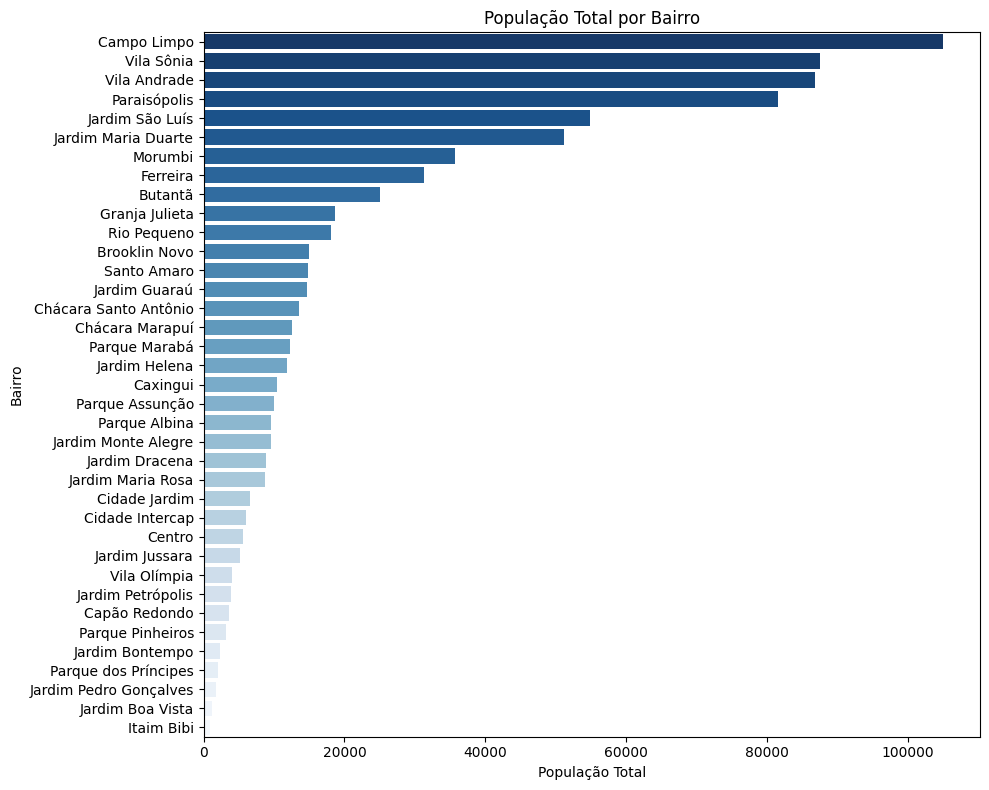


📊 População total por bairro:

01. Campo Limpo: 105.030 habitantes
02. Vila Sônia: 87.534 habitantes
03. Vila Andrade: 86.775 habitantes
04. Paraisópolis: 81.632 habitantes
05. Jardim São Luís: 54.870 habitantes
06. Jardim Maria Duarte: 51.122 habitantes
07. Morumbi: 35.642 habitantes
08. Ferreira: 31.306 habitantes
09. Butantã: 24.993 habitantes
10. Granja Julieta: 18.696 habitantes
11. Rio Pequeno: 18.057 habitantes
12. Brooklin Novo: 14.923 habitantes
13. Santo Amaro: 14.891 habitantes
14. Jardim Guaraú: 14.613 habitantes
15. Chácara Santo Antônio: 13.599 habitantes
16. Chácara Marapuí: 12.506 habitantes
17. Parque Marabá: 12.202 habitantes
18. Jardim Helena: 11.903 habitantes
19. Caxingui: 10.482 habitantes
20. Parque Assunção: 9.983 habitantes
21. Parque Albina: 9.627 habitantes
22. Jardim Monte Alegre: 9.501 habitantes
23. Jardim Dracena: 8.868 habitantes
24. Jardim Maria Rosa: 8.743 habitantes
25. Cidade Jardim: 6.540 habitantes
26. Cidade Intercap: 6.076 habitantes
27. Centro:

In [20]:
# Converter a coluna populacao_total para numérica
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce')

# Agrupar por bairro e somar a população
df_bairro = (
    df.groupby('Bairro', as_index=False)['populacao_total']
      .sum()
      .sort_values('populacao_total', ascending=False)
)

# Plotar gráfico (todos os bairros)
plt.figure(figsize=(10, 8))
sns.barplot(data=df_bairro, x='populacao_total', y='Bairro', palette='Blues_r')
plt.title('População Total por Bairro')
plt.xlabel('População Total')
plt.ylabel('Bairro')
plt.tight_layout()
plt.show()

# Exibir texto separado
print("\n📊 População total por bairro:\n")
for i, row in enumerate(df_bairro.itertuples(index=False), start=1):
    print(f"{i:02d}. {row.Bairro}: {int(row.populacao_total):,} habitantes".replace(',', '.'))

# Exibir total geral
total_pop = int(df_bairro['populacao_total'].sum())
print(f"\n👥 População total somada: {total_pop:,} habitantes".replace(',', '.'))


<div style=" background-color:#f9f9f9; border-left:6px solid #2b6cb0; padding:12px; color:#1a1a1a; font-size:15px; line-height:1.6; margin-top:10px; ">
<b>Observação:</b><br>
Os bairros com maior concentração populacional são <b>Campo Limpo</b> (105 mil habitantes), <b>Vila Sônia</b> (87 mil) e <b>Vila Andrade</b> (86 mil), compondo o principal eixo demográfico da região.

<br> Bairros como <b>Paraisópolis</b> (81 mil habitantes) e <b>Jardim São Luís</b> (54 mil) também apresentam grande densidade populacional, enquanto <b>Chácara Santo Antônio</b> e <b>Butantã</b> aparecem com população moderada. <br> A soma total chega a aproximadamente <b>793 mil habitantes</b>, indicando uma região altamente povoada e diversificada, com forte potencial de público para estratégias de comunicação e captação da escola. </div>

# 5. Renda Média por Bairro (em Salários Mínimos) — Do Mais Rico ao Mais Pobre

C:\Users\00157NLUC-BrenoR\AppData\Local\Temp\ipykernel_20504\2182451041.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='renda_sm', y='Bairro', data=df_bairro, palette='viridis')


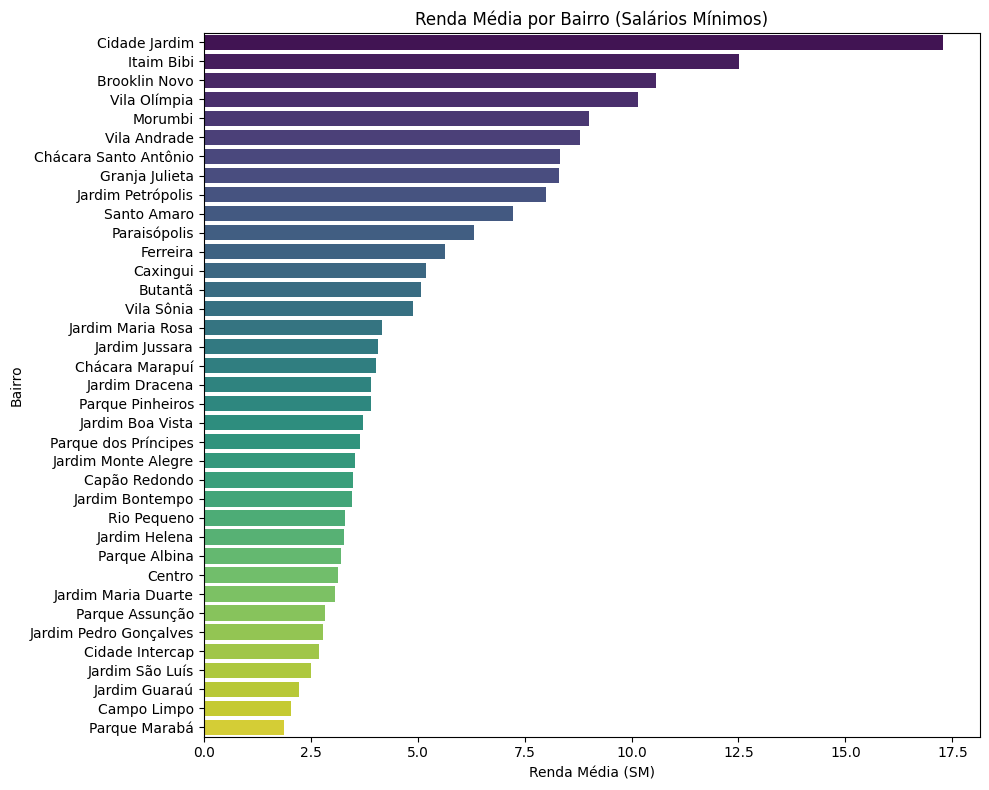


Renda Média por Bairro (em Salários Mínimos) - Do mais rico ao mais pobre:
                Bairro  renda_sm
         Cidade Jardim 17.280844
            Itaim Bibi 12.507719
         Brooklin Novo 10.576004
          Vila Olímpia 10.142749
               Morumbi  9.003143
          Vila Andrade  8.792923
 Chácara Santo Antônio  8.337266
        Granja Julieta  8.306222
     Jardim Petrópolis  8.007758
           Santo Amaro  7.221323
          Paraisópolis  6.324682
              Ferreira  5.647381
              Caxingui  5.197846
               Butantã  5.082374
            Vila Sônia  4.901362
     Jardim Maria Rosa  4.165863
        Jardim Jussara  4.079550
       Chácara Marapuí  4.037475
        Jardim Dracena  3.920101
      Parque Pinheiros  3.902995
      Jardim Boa Vista  3.717884
  Parque dos Príncipes  3.665406
   Jardim Monte Alegre  3.533576
         Capão Redondo  3.485804
       Jardim Bontempo  3.464216
           Rio Pequeno  3.312305
         Jardim Helena  3.276703


In [21]:
# Carregar o CSV com as variáveis demográficas
df = pd.read_csv('Elvira Brandão Morumbi - Euvira Brandão Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter renda_media: substituir vírgula por ponto
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

# Calcular renda em salários mínimos
salario_minimo = 1380.0
df['renda_sm'] = df['renda_media'] / salario_minimo

# Agrupar por bairro e calcular a renda média em SM
df_bairro = df.groupby('Bairro')[['renda_sm']].mean().reset_index()
df_bairro = df_bairro.sort_values('renda_sm', ascending=False)

# Plotando a renda média (SM) por bairro - gráfico horizontal (ordem decrescente)
plt.figure(figsize=(10, 8))
sns.barplot(x='renda_sm', y='Bairro', data=df_bairro, palette='viridis')
plt.title('Renda Média por Bairro (Salários Mínimos)')
plt.xlabel('Renda Média (SM)')
plt.ylabel('Bairro')
plt.tight_layout()
plt.show()

# Estatísticas por bairro
print("\nRenda Média por Bairro (em Salários Mínimos) - Do mais rico ao mais pobre:")
print(df_bairro.to_string(index=False))

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O gráfico de barras apresenta a renda média (em salários mínimos) dos bairros analisados, ordenada do maior para o menor valor. Essa visualização facilita a identificação dos contrastes de renda entre regiões próximas, evidenciando a concentração de maior poder aquisitivo em determinados bairros.
<br><br>
Os bairros com <b>maior renda média</b> são <b>Cidade Jardim</b> (≈ 17,28 SM), <b>Itaim Bibi</b> (≈ 12,50 SM), <b>Brooklin Novo</b> (≈ 10,57 SM) e <b>Vila Olímpia</b> (≈ 10,14 SM). Esses locais se destacam por abrigar áreas empresariais e residenciais de alto padrão.
<br><br>
Na faixa intermediária estão bairros como <b>Morumbi</b>, <b>Vila Andrade</b>, <b>Chácara Santo Antônio</b> e <b>Granja Julieta</b>, com rendas médias entre 8 e 9 SM, representando perfis de classe média alta.
<br><br>
Já os bairros com <b>menores rendas médias</b> incluem <b>Jardim São Luís</b> (≈ 2,50 SM), <b>Campo Limpo</b> (≈ 2,03 SM) e <b>Parque Marabá</b> (≈ 1,87 SM), refletindo realidades econômicas mais modestas.
<br><br>
De forma geral, observa-se um <b>forte gradiente socioeconômico</b> entre os bairros da região, em que áreas de alto padrão convivem próximas a zonas de menor renda. Essa heterogeneidade é um dos principais marcadores do cenário urbano de São Paulo, especialmente na zona sul.

</div>


# 6. Clustering de Áreas por Renda Média e População Total

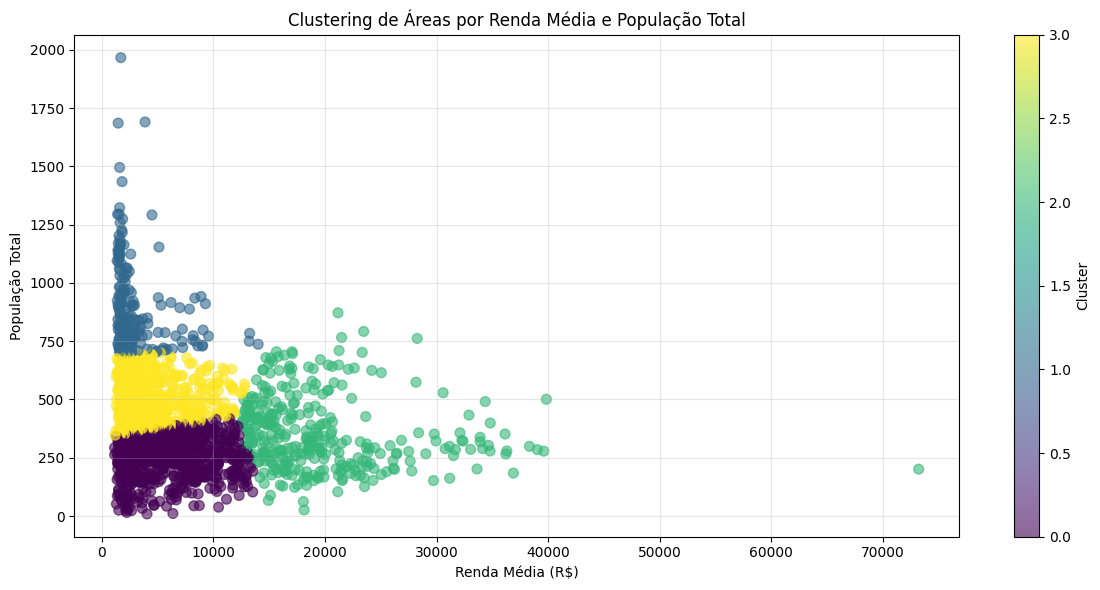


Estatísticas dos Clusters:

Cluster 0:
  Quantidade de áreas: 712
  Renda média (min - max): R$ 1,153.62 - R$ 13,541.14
  Renda média (média): R$ 6,197.11
  População total (min - max): 9 - 418
  População total (média): 250

Cluster 1:
  Quantidade de áreas: 194
  Renda média (min - max): R$ 1,376.52 - R$ 14,016.77
  Renda média (média): R$ 3,100.83
  População total (min - max): 692 - 1,967
  População total (média): 890

Cluster 2:
  Quantidade de áreas: 334
  Renda média (min - max): R$ 12,538.19 - R$ 73,198.95
  Renda média (média): R$ 19,505.91
  População total (min - max): 26 - 872
  População total (média): 356

Cluster 3:
  Quantidade de áreas: 641
  Renda média (min - max): R$ 1,198.23 - R$ 12,812.76
  Renda média (média): R$ 4,291.57
  População total (min - max): 347 - 700
  População total (média): 506


In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar os dados
df = pd.read_csv('Elvira Brandão Morumbi - Euvira Brandão Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter renda_media: substituir vírgula por ponto
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

# Converter população_total para numérico
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce')

# Remover linhas com NaN em renda_media ou populacao_total
data = df[['renda_media', 'populacao_total']].dropna()

# Normalizar os dados (importante para K-means)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# K-means clustering com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

# Adicionar as labels ao DataFrame
df_filtered = df[['renda_media', 'populacao_total']].dropna().copy()
df_filtered['cluster'] = clusters

# Plotando os clusters
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df_filtered['renda_media'], df_filtered['populacao_total'], 
                     c=df_filtered['cluster'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering de Áreas por Renda Média e População Total')
plt.xlabel('Renda Média (R$)')
plt.ylabel('População Total')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estatísticas dos clusters
print("\nEstatísticas dos Clusters:")
print("=" * 80)
for cluster_id in range(4):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Quantidade de áreas: {len(cluster_data)}")
    print(f"  Renda média (min - max): R$ {cluster_data['renda_media'].min():,.2f} - R$ {cluster_data['renda_media'].max():,.2f}")
    print(f"  Renda média (média): R$ {cluster_data['renda_media'].mean():,.2f}")
    print(f"  População total (min - max): {cluster_data['populacao_total'].min():,.0f} - {cluster_data['populacao_total'].max():,.0f}")
    print(f"  População total (média): {cluster_data['populacao_total'].mean():,.0f}")

In [23]:
# Criar uma cópia das linhas válidas e adicionar o cluster
df_clusters = df.copy()
df_clusters['cluster'] = clusters

# Juntar de volta com o dataframe original
df_final = df.merge(df_clusters[['renda_media', 'populacao_total', 'cluster']], 
                    on=['renda_media', 'populacao_total'], how='left')

# Salvar o novo CSV
df_final.to_csv('Elvira_Brandao_Morumbi_clusters.csv', index=False)

print("✅ Novo arquivo salvo com sucesso: Elvira_Brandao_Morumbi_clusters.csv")

✅ Novo arquivo salvo com sucesso: Elvira_Brandao_Morumbi_clusters.csv


<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O gráfico de dispersão mostra o resultado da técnica de <b>clustering K-means</b> aplicada sobre as variáveis <i>renda média</i> e <i>população total</i> das áreas analisadas. O objetivo é identificar <b>grupos com características socioeconômicas semelhantes</b> dentro do conjunto de dados.
<br><br>
Após a normalização dos valores, foram definidos <b>4 clusters</b>, representados por cores distintas no gráfico. Cada ponto corresponde a uma área ou CEP, posicionado conforme sua renda média (eixo X) e população total (eixo Y).
<br><br>
De forma geral, é possível observar:
<ul>
<li><b>Cluster 0</b> — Áreas de <b>baixa renda e alta densidade populacional</b>, predominantes nas regiões mais populosas e economicamente vulneráveis.</li>
<li><b>Cluster 1</b> — Regiões de <b>renda intermediária e densidade média</b>, com características mistas e maior heterogeneidade interna.</li>
<li><b>Cluster 2</b> — Bairros de <b>alta renda e baixa população</b>, representando áreas nobres e residenciais de padrão elevado.</li>
<li><b>Cluster 3</b> — Segmento de <b>renda baixa e população moderada</b>, provavelmente zonas periféricas em transição urbana.</li>
</ul>
<br>
A separação visual dos grupos evidencia como as <b>condições socioeconômicas se distribuem de forma desigual</b> na região. Essa análise é útil para identificar <b>perfis de áreas com potencial de captação de alunos</b>, permitindo compreender melhor o público-alvo, otimizar estratégias de comunicação e direcionar campanhas de forma mais assertiva conforme o perfil socioeconômico de cada cluster.

</div>
